In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import sklearn.preprocessing
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import scipy 
import pickle
import seaborn as sns
import os
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose as sd
warnings.filterwarnings('ignore')

In [2]:
def getPricesFromYahoo(folder='/tmp/'):
    """Downloads from Yahoo Finance website all the daily prices from components
        of DJI for the last 5 years and save each single stock dataframe inside a folder

    Args:
        folder (string): name of folder

    Returns:
        None
    """
    os.makedirs(os.path.dirname(folder), exist_ok=True)
    dji_wiki = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
    tickers = dji_wiki['Symbol'].to_list()
    for tck in tickers:
        df = yf.download(tck, period='5y', interval='1d')
        df = df.sort_index(ascending=False)
        df.to_pickle(f'{folder + tck}.pkl')
               

In [3]:
getPricesFromYahoo()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
def aggregateDf(folder='/tmp/'):
    """ Loops over all pickle files in the folder and aggregate daily adj close (for each stock)

    Args:
        folder (string): name of folder

    Returns:
        Pandas.dataFrame : dataframe containing daily adj close prices for each stock 
    """
    agg_df = None
    first = True
    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        df = pd.read_pickle(f)[['Adj Close']].rename({'Adj Close':filename[:-4]}, axis=1)
        if first:
            agg_df = df
            first = False
        else:
            agg_df = agg_df.merge(df, how='outer', on='Date')
    return agg_df

In [5]:
agg = aggregateDf()

In [6]:
agg.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-01,148.309998,285.940002,157.500000,175.779999,235.690002,147.000000,49.970001,182.490005,98.589996,51.070000,...,109.800003,254.690002,111.110001,149.250000,189.139999,536.909973,217.000000,38.330002,41.310001,153.369995
2022-11-30,148.029999,286.399994,157.589996,178.880005,236.410004,160.250000,49.720001,183.309998,97.870003,50.970001,...,110.120003,255.139999,109.690002,149.160004,189.809998,547.760010,217.000000,38.980000,41.500000,152.419998
2022-11-29,141.169998,281.989990,154.419998,175.320007,235.119995,151.679993,48.279999,181.029999,94.690002,50.650002,...,108.839996,240.330002,106.250000,145.479996,187.210007,528.000000,209.059998,38.340000,41.080002,152.970001
2022-11-28,144.220001,282.619995,150.869995,171.830002,232.300003,153.690002,48.080002,178.360001,95.690002,49.500000,...,108.449997,241.759995,104.959999,146.600006,186.320007,532.270020,211.259995,38.240002,40.810001,153.509995
2022-11-25,148.110001,283.739990,154.149994,178.360001,235.699997,153.350006,48.400002,183.699997,98.870003,50.841038,...,107.500000,247.490005,105.959999,146.720001,188.910004,537.619995,213.789993,39.020000,41.660000,153.070007


In [7]:
def createReturns(horizons =[1,5,10,20,30]):
    """ Computes for each stock and for each horizon the stock's return over "horizon" days

    Args:
        horizons (list<int>) : list of horizons to be used for calculating the returns

    Returns:
        Pandas.dataFrame : dataframe containing returns for each stock for every horizon in horizons
    """
    returns = pd.DataFrame()
    for stock in agg.columns:
        returns[stock] = agg[stock]
        for horizon in horizons:
            returns["R_" + stock + "_" + str(horizon)] = agg[stock].pct_change(-horizon)
    return returns

In [8]:
returns = createReturns(horizons =[1,5,10,20,30])

In [9]:
returns.head()

,AAPL,R_AAPL_1,R_AAPL_5,R_AAPL_10,R_AAPL_20,R_AAPL_30,AMGN,R_AMGN_1,R_AMGN_5,R_AMGN_10,...,R_WBA_5,R_WBA_10,R_WBA_20,R_WBA_30,WMT,R_WMT_1,R_WMT_5,R_WMT_10,R_WMT_20,R_WMT_30
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-01,148.309998,0.001892,-0.018270,-0.003226,0.024312,0.032643,285.940002,-0.001606,0.008963,0.007647,...,-0.010776,0.022778,0.167167,0.251759,153.369995,0.006233,0.006233,0.032795,0.089662,0.146606
2022-11-30,148.029999,0.048594,-0.014316,-0.013396,-0.015761,0.031482,286.399994,0.015639,-0.002264,0.016829,...,-0.006939,0.020910,0.157983,0.268534,152.419998,-0.003595,0.004812,0.033776,0.075729,0.136276
2022-11-29,141.169998,-0.021148,-0.046213,-0.047950,-0.077839,-0.007063,281.989990,-0.002229,-0.021412,-0.004794,...,0.012072,0.013320,0.138727,0.259501,152.970001,-0.003518,0.012041,0.105354,0.074756,0.164421
2022-11-28,144.220001,-0.026264,-0.046731,-0.036607,-0.072433,0.043931,282.619995,-0.003947,-0.016255,-0.001591,...,0.026667,0.000736,0.128768,0.242189,153.509995,0.002874,0.021833,0.076659,0.077188,0.176953
2022-11-25,148.110001,-0.019594,-0.017317,0.008443,0.024556,0.037525,283.739990,0.001200,-0.012391,-0.018266,...,0.038126,0.095099,0.181675,0.252611,153.070007,0.004265,0.034257,0.075232,0.087686,0.157167


# Descriptive statistics and data cleaning

In this section, we will give descriptive statistics and clean data as much as possible. For the sake of simplicity, we will work primarly on Apple stock's returns. The same process can be done to other stocks.

In [10]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
returns = createReturns(horizons =[1,5,10,20,30])
returns.describe()

,AAPL,R_AAPL_1,R_AAPL_5,R_AAPL_10,R_AAPL_20,R_AAPL_30,AMGN,R_AMGN_1,R_AMGN_5,R_AMGN_10,R_AMGN_20,R_AMGN_30,AXP,R_AXP_1,R_AXP_5,R_AXP_10,R_AXP_20,R_AXP_30,BA,R_BA_1,R_BA_5,R_BA_10,R_BA_20,R_BA_30,CAT,R_CAT_1,R_CAT_5,R_CAT_10,R_CAT_20,R_CAT_30,CRM,R_CRM_1,R_CRM_5,R_CRM_10,R_CRM_20,R_CRM_30,CSCO,R_CSCO_1,R_CSCO_5,R_CSCO_10,R_CSCO_20,R_CSCO_30,CVX,R_CVX_1,R_CVX_5,R_CVX_10,R_CVX_20,R_CVX_30,DIS,R_DIS_1,R_DIS_5,R_DIS_10,R_DIS_20,R_DIS_30,DOW,R_DOW_1,R_DOW_5,R_DOW_10,R_DOW_20,R_DOW_30,GS,R_GS_1,R_GS_5,R_GS_10,R_GS_20,R_GS_30,HD,R_HD_1,R_HD_5,R_HD_10,R_HD_20,R_HD_30,HON,R_HON_1,R_HON_5,R_HON_10,R_HON_20,R_HON_30,IBM,R_IBM_1,R_IBM_5,R_IBM_10,R_IBM_20,R_IBM_30,INTC,R_INTC_1,R_INTC_5,R_INTC_10,R_INTC_20,R_INTC_30,JNJ,R_JNJ_1,R_JNJ_5,R_JNJ_10,R_JNJ_20,R_JNJ_30,JPM,R_JPM_1,R_JPM_5,R_JPM_10,R_JPM_20,R_JPM_30,KO,R_KO_1,R_KO_5,R_KO_10,R_KO_20,R_KO_30,MCD,R_MCD_1,R_MCD_5,R_MCD_10,R_MCD_20,R_MCD_30,MMM,R_MMM_1,R_MMM_5,R_MMM_10,R_MMM_20,R_MMM_30,MRK,R_MRK_1,R_MRK_5,R_MRK_10,R_MRK_20,R_MRK_30,MSFT,R_MSFT_1,R_MSFT_5,R_MSFT_10,R_MSFT_20,R_MSFT_30,NKE,R_NKE_1,R_NKE_5,R_NKE_10,R_NKE_20,R_NKE_30,PG,R_PG_1,R_PG_5,R_PG_10,R_PG_20,R_PG_30,TRV,R_TRV_1,R_TRV_5,R_TRV_10,R_TRV_20,R_TRV_30,UNH,R_UNH_1,R_UNH_5,R_UNH_10,R_UNH_20,R_UNH_30,V,R_V_1,R_V_5,R_V_10,R_V_20,R_V_30,VZ,R_VZ_1,R_VZ_5,R_VZ_10,R_VZ_20,R_VZ_30,WBA,R_WBA_1,R_WBA_5,R_WBA_10,R_WBA_20,R_WBA_30,WMT,R_WMT_1,R_WMT_5,R_WMT_10,R_WMT_20,R_WMT_30
count,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,935.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000,1258.000000,1257.000000,1253.000000,1248.000000,1238.000000,1228.000000
mean,95.326205,0.001256,0.006049,0.012237,0.024666,0.037844,202.099760,0.000623,0.003035,0.006099,0.012146,0.017075,123.371954,0.000704,0.003325,0.006291,0.011991,0.017246,257.042458,0.000185,0.001437,0.001988,0.003623,0.002007,156.571510,0.000726,0.003630,0.007239,0.013577,0.017581,182.110509,0.000606,0.003007,0.005471,0.010465,0.015498,44.439472,0.000515,0.002332,0.004534,0.008373,0.011635,105.424277,0.000755,0.003678,0.007504,0.014901,

#### Commentary :  
We can easily check that the dataset we obtain after computing the results corresponding to each horizon is correct. However, and since the there is missing data for the "DOW" stock before 2019-03-20, we chose to drop it. This decision is corroborated by the stock's high correlation to other index' stocks, as we can see below : 85% correlation with AXP, 90% correlation with CAT, 82% with GS, 86% with HON and 80% with JPM

In [11]:
agg.corr()["DOW"]

AAPL    0.721252
AMGN    0.458906
AXP     0.849787
BA     -0.148511
CAT     0.906433
CRM     0.494077
CSCO    0.622194
CVX     0.482617
DIS     0.517258
DOW     1.000000
GS      0.818543
HD      0.712846
HON     0.867542
IBM     0.682728
INTC    0.031132
JNJ     0.758885
JPM     0.804701
KO      0.668362
MCD     0.701981
MMM     0.519685
MRK     0.316622
MSFT    0.720922
NKE     0.719282
PG      0.707424
TRV     0.777944
UNH     0.671449
V       0.755495
VZ      0.121321
WBA     0.331352
WMT     0.628808
Name: DOW, dtype: float64

Here we define multiple statistics in order to describe the data :
- annualized return
- annualized vol
- sharpe ratio (annualized return / annualized vol)
- drawdown
- skewness
- kurtosis
- historic var (Value-at-Risk)
- cvar (Conditional Value-at-Risk)

In [12]:
def sharpe_ratio(returns):
    """Compute a sharpe ratio given a list of daily return (assuming 252 day a year)

    Args:
        returns (List<float>): List containing daily returns

    Returns:
        float: sharpe ratio defined as annualized return / annualized volatility
    """
    returns = returns.dropna()
    vol_alloc = annualized_vol(returns)
    annualized_return = annualized_returns(returns)
    return annualized_return / vol_alloc

def sharpe_ration_DIJ(returns):
    """Compute sharpes ratios for all the stocks

    Args:
        returns (List<float>): List containing daily returns of different stocks

    Returns:
        sharpe_ratios (dict<string,float>) : sharpe ratios
    """
    sharpe_ratios = dict()
    for stock in agg.columns:
        sharpe_ratios[stock] = sharpe_ratio(returns["R_"+stock+"_1"])
    return sharpe_ratios
    


def heatmap_log_returns(returns, horizon):
    """Plots a correlation heatmap of returns of the different stocks over a specified horizon

    Args:
        returns (List<float>): List containing all the returns with differnt horizons
        horizon (int) : horizon of the returns series we wish to adress

    Returns:
        heatmap : Correlation heatmap of the chosen series
    """
    df = pd.DataFrame()
    log_returns = np.log(returns.dropna()+1)
    for stock in agg.columns:
        df["R_"+stock+"_"+str(horizon)] = log_returns["R_"+stock+"_"+str(horizon)]
    sns.heatmap(df.corr())
    
    
def drawdown(returns):
    """Compute drawdown

    Args:
        returns (List): list of returns

    Returns:
        float: drawdown
    """
    strat = pd.Series(np.cumprod(1 + returns[::-1]))
    Roll_Max = strat.cummax()
    Daily_Drawdown = strat/Roll_Max - 1.0

    return Daily_Drawdown.min()

def skewness(returns):
    """Compute skewness

    Args:
        returns (List): list of returns

    Returns:
        float: skewness
    """
    return scipy.stats.skew(returns)

def kurtosis(returns):
    """Compute kurtosis

    Args:
        returns (List): list of returns

    Returns:
        float: kurtosis
    """
    return scipy.stats.kurtosis(returns)

def var_historic(returns, level=5):
    """Compute VAR based on historic data

    Args:
        returns (List): list of returns
        level (int, optional): Percentile to use to compute var. Defaults to 5.

    Returns:
        float: var_historic
    """
    return -np.percentile(returns, level)

def cvar_historic(returns, level=5):
    """Compute Cvar based on historic data

    Args:
        returns (List): list of returns
        level (int, optional): Percentile to use to compute cvar. Defaults to 5.

    Returns:
        float: cvar
    """
    is_beyond = returns <= var_historic(returns, level=level)
    return -returns[is_beyond].mean()

def annualized_returns(returns):
    """Compute an annualized return

    Args:
        returns (List): list of returns

    Returns:
        float: annualized return
    """
    strat = np.cumprod(1 + returns[::-1])
    return ((strat[-1]/strat[0]) ** (252/(len(strat))) - 1)

def annualized_vol(returns):
    """Compute an annualized vol

    Args:
        returns (List): list of returns

    Returns:
        float: annualized volatility
    """
    return np.std(np.log(1 + returns)) * np.sqrt(252)
    
def summary_stats(returns):
    """Compute summary statistics

    Args:
        returns (List): list of returns

    Returns:
        DataFrame: DataFrame containing main indicators
    """
    ann_r = annualized_returns(returns)
    ann_vol = annualized_vol(returns)
    ann_sr = ann_r / ann_vol
    dd = drawdown(returns)
    skew = skewness(returns)
    kurt = kurtosis(returns)
    cf_var5 = var_historic(returns)
    hist_cvar5 = cvar_historic(returns)

    return pd.DataFrame({
        "Annualized Return (%)": [100 * ann_r],
        "Annualized Vol (%)": [100 * ann_vol],
        "Sharpe ratio":[ann_r / ann_vol],
        "Skewness": [skew],
        "Kurtosis": [kurt],
        "Cornish-Fisher VaR (5%) (%)": [100 * cf_var5],
        "Historic CVaR (5%) (%)": [100 * hist_cvar5],
        "Max Drawdown (%)": [100 * dd],
        "Max Drawdown / vol": [dd / ann_vol],
    })

In [13]:
summary_stats(returns["R_AAPL_1"].dropna())

,Annualized Return (%),Annualized Vol (%),Sharpe ratio,Skewness,Kurtosis,Cornish-Fisher VaR (5%) (%),Historic CVaR (5%) (%),Max Drawdown (%),Max Drawdown / vol
0,29.832509,33.330363,0.895055,-0.029832,4.585805,3.22481,0.129901,-38.515903,-1.15558


Let's see how correlated are our daily log-returns : 

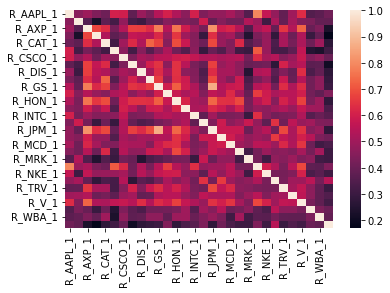

In [14]:
heatmap_log_returns(returns, 1)

We note that the daily log returns are almost all positively correlated, which should be no surprise since they take part in the same index. If a stock has a bad or good performance, it affects in the same way the index and thus all the other stocks.

We want to check if there is some **seasonality** or **trend** in the returns (especially the daily returns).

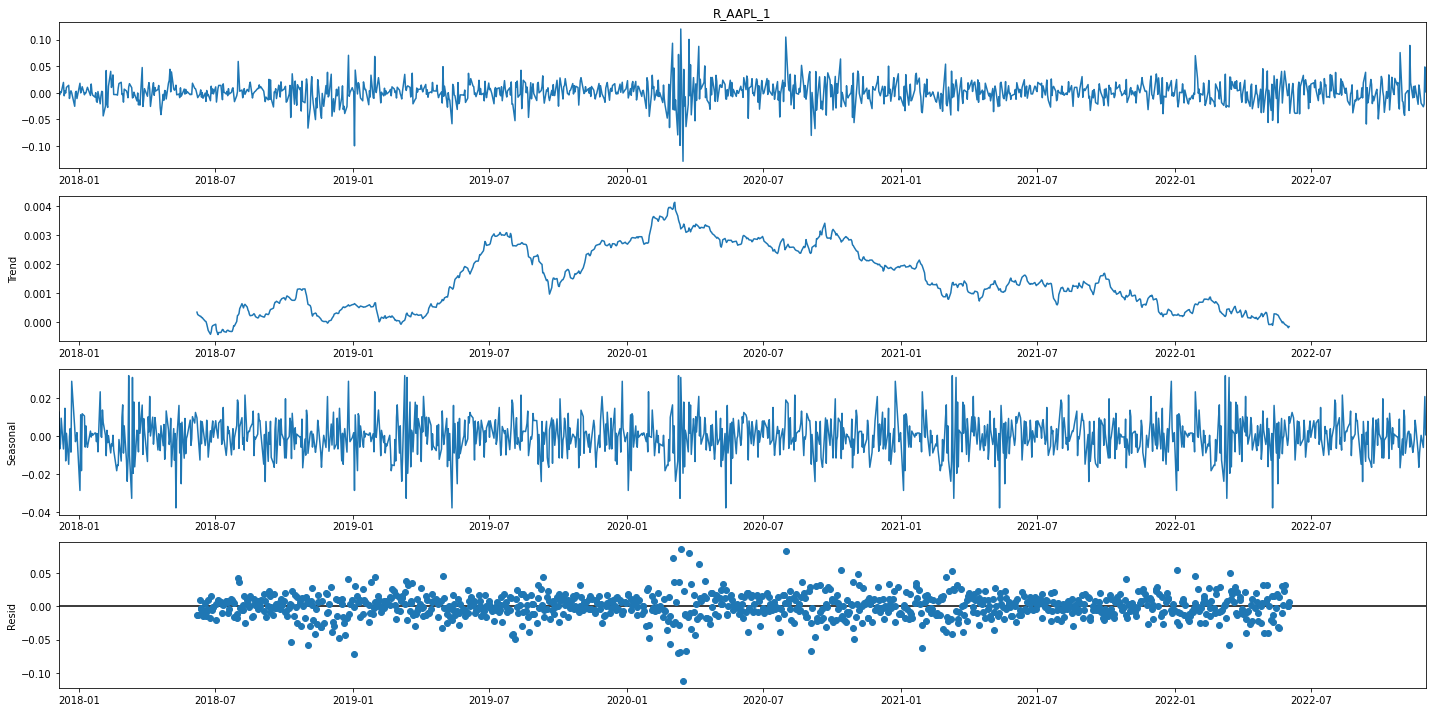

In [15]:
def seasonal_decomposition_additive_model(returns, stock_return):   
    df_series = returns.sort_index(ascending=True).asfreq('D')
    series = pd.Series(df_series[stock_return], index= returns.sort_index().index)
    series.dropna(inplace=True)
    results = sd(series, model='additive',period = 252)
    plt.rcParams['figure.figsize'] = (20.0, 10.0)
    results.plot()
    plt.show()

seasonal_decomposition_additive_model(returns, "R_AAPL_1")

We see for example that for Apple stock, we can't detect seasonality nor a trend.  
We will for the sake of the prediction part look for normally distributed data. To do so, we will use **Kolmogorov-Smirnov** and **Shapiro-Wilk** tests as show below :

In [16]:
# Normality tests : Kolmogorv-Smirnov and Shapiro-Wilk tests for normality
print(scipy.stats.kstest(returns["R_AAPL_1"].dropna(), scipy.stats.norm().cdf))
print(scipy.stats.shapiro(returns["R_AAPL_1"].dropna()))

KstestResult(statistic=0.4694437798589943, pvalue=1.4563093013439443e-254)
ShapiroResult(statistic=0.9476972222328186, pvalue=1.0357409561937757e-20)


Seeing that our data are not normally distributed, We will try to apply **Yeo - Johnson**'s transformation on our daily

In [17]:
# Yeo-Johnson transformation
horizons =[1,5,10,20,30]
returns_yeoJohnson = returns.copy()
for stock in agg.columns:
    for horizon in horizons:
        returns_yeoJohnson["R_"+stock+"_"+str(horizon)] = sklearn.preprocessing.power_transform(returns["R_"+stock+"_"+str(horizon)].values.reshape(-1,1), method='yeo-johnson')


KstestResult(statistic=0.06943175729350651, pvalue=1.0298740388867865e-05)
Figure(1440x720)


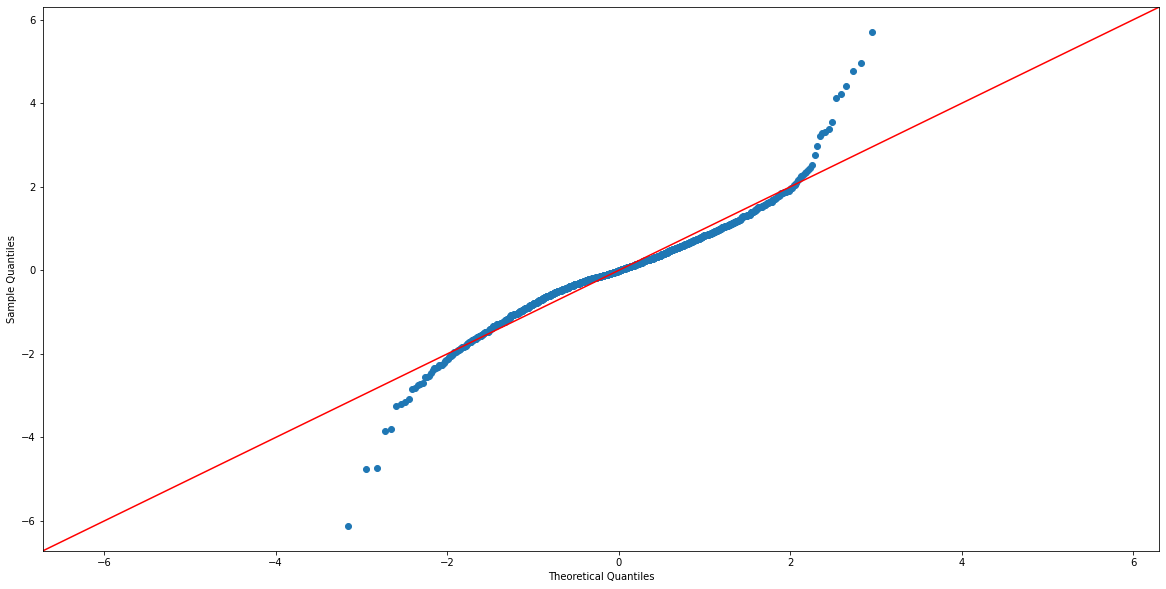

In [18]:
print(scipy.stats.kstest(returns_yeoJohnson["R_AAPL_1"].dropna(), scipy.stats.norm().cdf))
print(sm.qqplot(returns_yeoJohnson["R_AAPL_1"], line ='45'))

In [19]:
print("kurtosis : ", kurtosis(returns_yeoJohnson["R_AAPL_1"].dropna()), "\nskewness : ", skewness((returns_yeoJohnson["R_AAPL_1"].dropna())))

kurtosis :  4.585198701363628 
skewness :  0.007693857277324692


### Commentary :  
Even though the QQ-plot shapes better fitting to a normal distribution, the kstest still rejects the normality hypothesis. We will therefore not apply any transformation on our data in the prediction section and keep it as it is.

# Prediction


In this section, we will try to predict the forward return of the different stocks. We will consider one particular stock and develop our model (the same procedure can be applied to each stock).  
There are multiple features that could be used to predict our forward returns, such as : 
- Daily traded volume
- Opening price
- Average volume
- Market cap, etc.

These are all important features that would increase the efficiency of our forecasting model.  
However, it is asked to come up with or create meaningful features to predict as much as possible the forward returns. Thus, we won't use any outside information that isn't included in our dataset (returns)and instead we will start first with extracting information from the dates. In fact, investors decisions vary a lot from one quarter to another, especially at the end of each year. We would like to include this feature in our model. We would like also to include a returns **moving average** feature and some of the **returns' lags**.

In [20]:
""" We create our target columns and name them F_stock_1 
"""
targets = agg.pct_change(-1).shift(1)
new_names = dict()
for stock in targets.columns:
    new_names[stock] = "F_"+stock+"_1"
targets.rename(columns=new_names, inplace=True)

In [21]:
targets.head()

,F_AAPL_1,F_AMGN_1,F_AXP_1,F_BA_1,F_CAT_1,F_CRM_1,F_CSCO_1,F_CVX_1,F_DIS_1,F_DOW_1,F_GS_1,F_HD_1,F_HON_1,F_IBM_1,F_INTC_1,F_JNJ_1,F_JPM_1,F_KO_1,F_MCD_1,F_MMM_1,F_MRK_1,F_MSFT_1,F_NKE_1,F_PG_1,F_TRV_1,F_UNH_1,F_V_1,F_VZ_1,F_WBA_1,F_WMT_1
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-30,0.001892,-0.001606,-0.000571,-0.017330,-0.003046,-0.082683,0.005028,-0.004473,0.007357,0.001962,-0.006060,0.009507,-0.009838,0.001746,-0.007981,0.004157,-0.014040,0.002830,0.002236,0.000159,-0.002906,-0.001764,0.012946,0.000603,-0.003530,-0.019808,0.000000,-0.016675,-0.004578,0.006233
2022-11-29,0.048594,0.015639,0.020528,0.020306,0.005487,0.056501,0.029826,0.012595,0.033583,0.006318,0.012959,0.031618,0.013058,0.016452,0.040484,0.010847,0.011863,0.025306,0.010745,-0.001269,0.011760,0.061624,0.032376,0.025296,0.013888,0.037424,0.037980,0.016693,0.010224,-0.003595
2022-11-28,-0.021148,-0.002229,0.023530,0.020311,0.012139,-0.013078,0.004160,0.014970,-0.010450,0.023232,0.003531,-0.009281,0.004403,0.002121,0.005917,-0.006993,0.016450,-0.003509,-0.005387,0.011954,0.003596,-0.005915,0.012290,-0.007640,0.004777,-0.008022,-0.010414,0.002615,0.006616,-0.003518
2022-11-25,-0.026264,-0.003947,-0.021278,-0.036611,-0.014425,0.002217,-0.006612,-0.029069,-0.032163,-0.026377,-0.016716,-0.022857,-0.019450,-0.014760,-0.020791,0.000508,-0.017478,0.000160,-0.007709,-0.034098,0.008837,-0.023152,-0.009438,-0.000818,-0.013710,-0.009951,-0.011834,-0.019990,-0.020403,0.002874


In [22]:
cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday'],
                            ordered=True)

def create_features(dataframe):
    """
    Creates features from datetime index.
    """
    df = dataframe.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
        
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    return X

new_features =  create_features(agg)

In [23]:
new_features.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season
Date,,,,,,,,,
2022-12-01,3,4,12,2022,335,1,48,Thursday,Fall
2022-11-30,2,4,11,2022,334,30,48,Wednesday,Fall
2022-11-29,1,4,11,2022,333,29,48,Tuesday,Fall
2022-11-28,0,4,11,2022,332,28,48,Monday,Fall
2022-11-25,4,4,11,2022,329,25,47,Friday,Fall


In [24]:
""" move to dummies 
"""
new_features = pd.get_dummies(create_features(agg), drop_first=True)

In [25]:
new_features.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,season_Summer,season_Fall,season_Winter
Date,,,,,,,,,,,,,,
2022-12-01,3,4,12,2022,335,1,48,0,0,1,0,0,1,0
2022-11-30,2,4,11,2022,334,30,48,0,1,0,0,0,1,0
2022-11-29,1,4,11,2022,333,29,48,1,0,0,0,0,1,0
2022-11-28,0,4,11,2022,332,28,48,0,0,0,0,0,1,0
2022-11-25,4,4,11,2022,329,25,47,0,0,0,1,0,1,0


Let us focus on a particular stock : **"AAPL"**. In order to determine which are the most efficient return lags (or forward lags but shifted), we will plot an ACF. In practice, if we want to predict the forward return for tomorrow, we would need to do an ACF on a particular time window, for instance a 200-days window ending with today, and then determine the most efficient lags. In this case with the Apple stock, we found that the lags **2,10** and **26** days were the more correlated to the actual daily forwards. We will be taking those as potential features, in addition to the daily returns themselves, the quarter and the moving average.

Figure(1440x720)


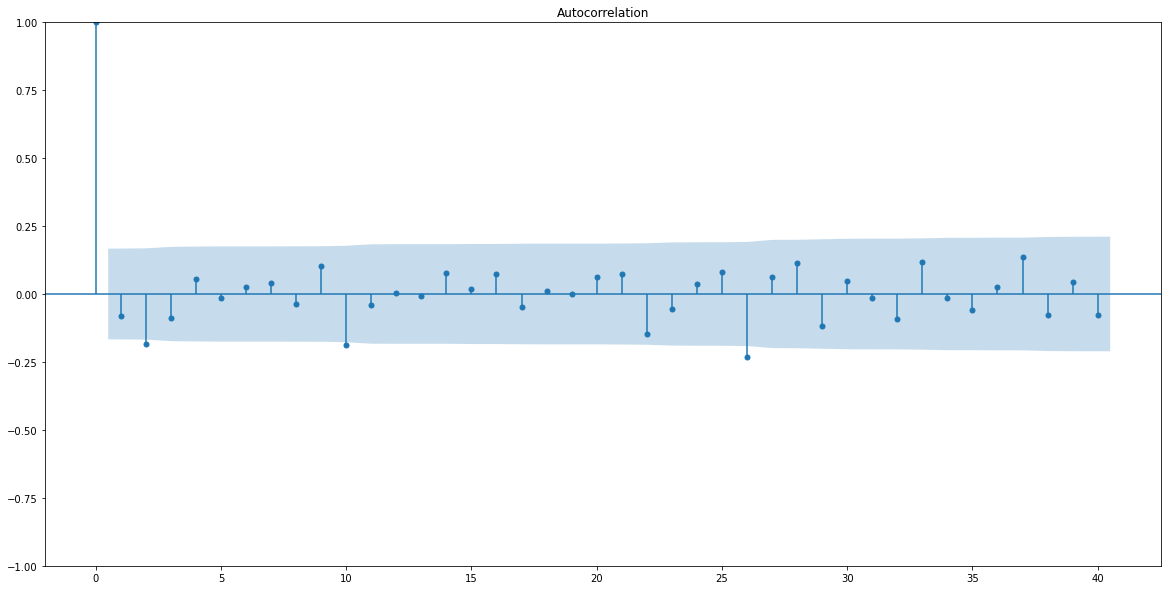

In [26]:
y = datetime.datetime.strptime("01/01/2020","%d/%m/%Y")
df = targets["F_AAPL_1"].loc[(targets["F_AAPL_1"].index < y) & (targets["F_AAPL_1"].index > y-timedelta(days=200))]
print(plot_acf(df.dropna(), lags=40))

The 26 days, 10 days and 2 days lags seem the most efficient lag.

We will test the statistical significance of our features below :

In [27]:
model_regression = LinearRegression()
dataset = pd.DataFrame()
stock = "AAPL"
stock_return = "R_"+stock+"_1"


# dataset['quarter'] = new_features['quarter']
dataset['lag_26_F'] = targets["F_"+stock+"_1"].shift(-26)
# dataset['lag_10_F'] = targets["F_"+stock+"_1"].shift(-10)
# dataset['lag_2_F'] = targets["F_"+stock+"_1"].shift(-2)
dataset["R_"+stock+"_1"] = returns["R_"+stock+"_1"]
dataset["F_"+stock+"_1"] = targets["F_"+stock+"_1"]
dataset.dropna(inplace=True)


dataset["EWN_"+stock] = dataset["R_"+stock+"_1"].ewm(alpha=0.45).mean()
# dataset["MA_"+stock] = dataset["R_"+stock+"_1"].rolling(window=10).sum()
dataset.dropna(inplace=True)

""" We create our train_sets and test_sets
"""
splits = []
for y in dataset.index:
    if (y > datetime.datetime.strptime("01/01/2020","%d/%m/%Y")):
        dfx = dataset.loc[(dataset.index < y) & (dataset.index > y-timedelta(days=200))]
        dfy = dataset.loc[dataset.index == y]
        splits.append([dfx,dfy])

""" We check the significance of our features in an exemple 
"""
test_set = splits[-1][1]
train_set = splits[-1][0]
regr = OLS(train_set["F_"+stock+"_1"], add_constant(train_set.drop("F_"+stock+"_1", axis=1))).fit()
test_set['const'] = 1.0
print(regr.summary())
test_set.insert(0, 'const', test_set.pop('const'))
test_prediction = regr.predict(test_set.drop("F_"+stock+"_1", axis=1))

                            OLS Regression Results                            
Dep. Variable:               F_AAPL_1   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     118.5
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           1.60e-37
Time:                        07:57:02   Log-Likelihood:                 481.41
No. Observations:                 138   AIC:                            -954.8
Df Residuals:                     134   BIC:                            -943.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.001     -3.374      0.0

As we can see, we have a good adjusted R squared and the 26 days daily return lag, as well as the daily return and the Exponentially weighted mean are all statistically significant to our test. However, after trying it on different windows (on which we do an ACF and determine lags) and concluded that depending on the size of the window and on the trainset, the impact of the lags differ. We will keep working with a 200 day window. However, one must determine the most relevant window depending on the use case.  
  
We will below forecast forward returns using only the 26th lag and the EWM from 01/01/2020 onwards :

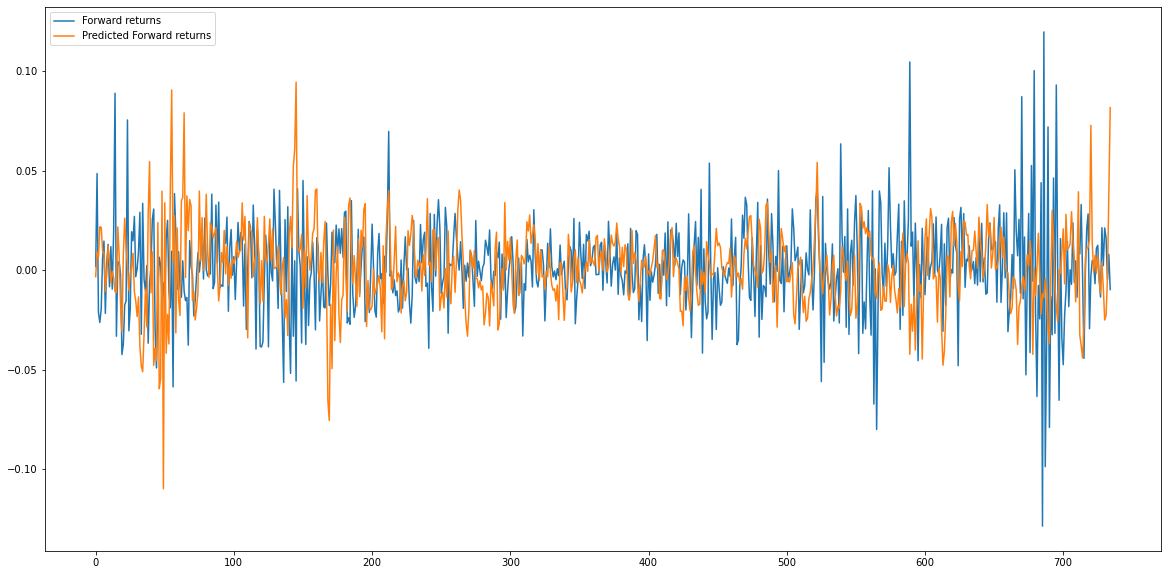

In [28]:
predictions = []
for split in splits[::-1]:
    test_set = split[1]
    train_set = split[0]
    regr = OLS(train_set["F_"+stock+"_1"], add_constant(train_set.drop("F_"+stock+"_1", axis=1))).fit()
    test_set['const'] = 1.0
    test_set.insert(0, 'const', test_set.pop('const'))
    test_prediction = regr.predict(test_set.drop("F_"+stock+"_1", axis=1))
    predictions.append(test_prediction[0])

    
"""We plot here the predictions against the actual forward returns for dates greater than 01/01/2020
"""
forward_returns = list(dataset["F_"+stock+"_1"].loc[dataset.index > datetime.datetime.strptime("01/01/2020","%d/%m/%Y") ])
plt.plot(forward_returns)
plt.plot(predictions)
plt.legend(["Forward returns", "Predicted Forward returns"])

In [29]:
print(mean_absolute_error(predictions, forward_returns)/dataset["F_"+stock+"_1"].loc[dataset.index > datetime.datetime.strptime("01/01/2020","%d/%m/%Y") ].mean())

18.55858221896722


With Apple stock, we have an average error of 18% on forward returns.

### Commentary :  
We can conclude from this study that : 
- We chose to train our data over 200 days in order to predict the forward return on the 201st day.
- The most important features are : the daily returns, the forward returns lags of 26 days, and the exponential weighted mean with an alpha of .
- Throughout the tests, we realized the quarter and date features aren't statistically signficant (with a p-value each time greater than 0.4), we won't be considering them.
- We realized that the EWM provides better results than the MA (Moving Average) feature. One can move the alpha to weight in more or less more recent returns.
- We can replicate the same approach in order to forecast forward returns for all stocks at a given date : 
 -  Determining which window length would be used for training sets
 -  Plotting an ACF plot to determine the potential most efficient forward lags
 -  Creating an EWM or MA feature (or both if we replace the lag feature with a moving average and keep the EWA feature as well)
 -  Repeating the same approach for other dates
 
- We can also deduce that the 26 days lag we chose isn't right for all dates. We studied the significancy of this lag for different trainsets for different dates, and we clearly noticed that depending on the time window we chose (to which we do an ACF and then deduce the lags), the most efficient lags can change. Therefore, it is advised to do this process at each date seperately, by fixing a window from where we deduce the most efficient lags as well as a window of training.

- We can further improve our model by using relevant features from the market data such as Daily traded volume, Opening price, Average volume, Market cap, etc.

# Trading strategy


For this section, we are settling for a naive trading strategy, giving each stock a weight of 1 or 0 at each date. The idea rely on trend following : if we are trading an uptrend, we should continue holding to our position, if not then we set our allocation to 0. We assume that our portfolio will be 100% stock or 100% cash with no interest gained on cash (and therefore not reinvested in the stock itself) as well as no trading fees.

We'll start by considering the Apple stock as an example : 

In [54]:
stock_return = "R_AAPL_1"
stock = "AAPL"
stock_returns = returns[stock_return].sort_index(ascending=True)

In [55]:
sharpe_ratio(stock_returns)

0.8928437387618045

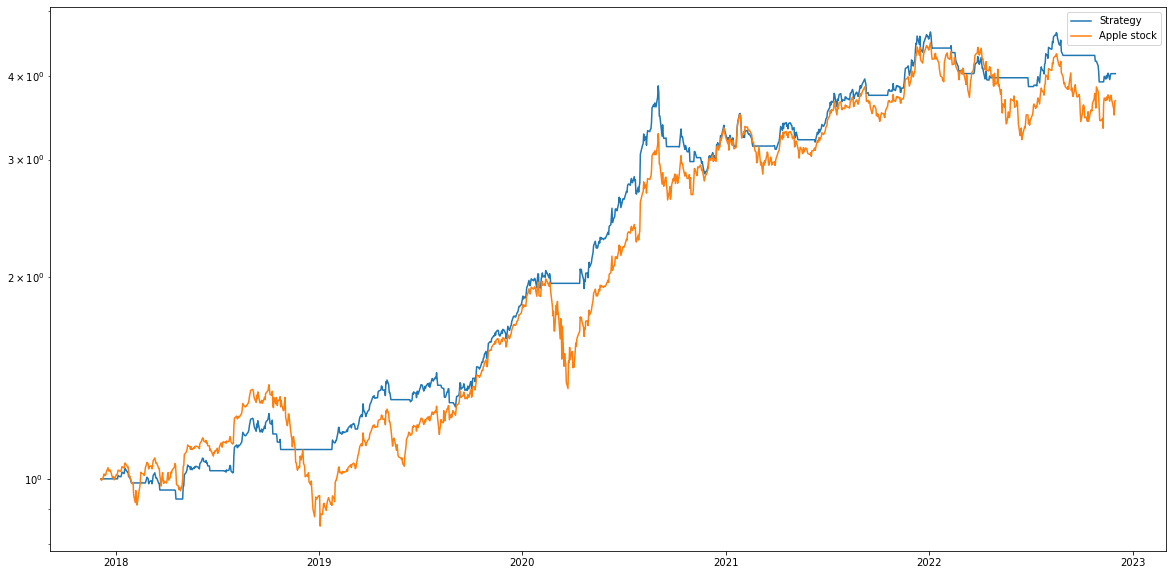

In [63]:
df = pd.DataFrame()
df[stock] = agg[stock].sort_index(ascending=True)
portfolio = [1 if df[stock].rolling(window=21).mean().pct_change()[_] > 0 else 0 for _ in df.index]
df_port = pd.DataFrame(portfolio[:-1], index=df.index[1:], columns=["Allocation"])
plt.plot(np.cumprod(1 + np.multiply(df_port["Allocation"], stock_returns)))
plt.plot(np.cumprod(1 + stock_returns))
plt.legend(["Strategy", "Apple stock"])
plt.yscale('log')

In [64]:
sharpe_ratio(np.multiply(df_port["Allocation"], stock_returns))

1.5565154587879744

In [65]:
excess_sharpe_ratio = sharpe_ratio(np.multiply(df_port["Allocation"], stock_returns)) - sharpe_ratio(stock_returns)
excess_sharpe_ratio

0.6636717200261699

In [66]:
drawdown(np.multiply(df_port["Allocation"], stock_returns))*100

-26.078063865970115

Usually, investors prefer a drowdown as low as possible, but that doesn't get more than 25%. In our case, our maximum drawdown is indeed too important.

In [67]:
drawdown(np.multiply(df_port["Allocation"], stock_returns))/annualized_vol(np.multiply(df_port["Allocation"], stock_returns))

-1.2587720746110396

We see that we obtain a far better sharpe ratio for a long strategy using trend following with a moving average, as a well a good drawdown/vol of -1.196. Usually a good drawdown/vol should be between -2 ans -1.

We will try and slightly improve the strategy using the same technique, except we are giving more weight to recent returns with an exponential weighted average :

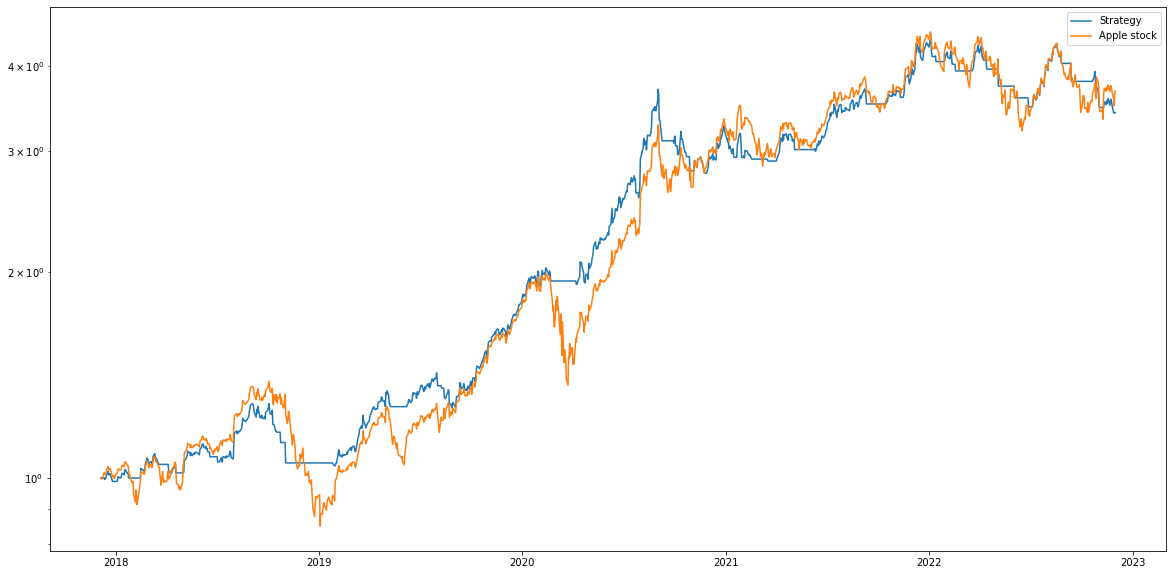

In [96]:
portfolio = [1 if df[stock].ewm(span=25, adjust=False).mean().pct_change()[_] > 0 else 0 for _ in df.index]
df_port = pd.DataFrame(portfolio[:-1], index=df.index[1:], columns=["Allocation"])
stock_returns = returns[stock_return].sort_index(ascending=True)

plt.plot(np.cumprod(1 + np.multiply(df_port["Allocation"], stock_returns)))
plt.plot(np.cumprod(1 + stock_returns))
plt.legend(["Strategy", "Apple stock"])
plt.yscale('log')

In [97]:
sharpe_ratio(np.multiply(df_port["Allocation"], stock_returns))

1.3056387858721847

In [98]:
excess_sharpe_ratio = sharpe_ratio(np.multiply(df_port["Allocation"], stock_returns)) - sharpe_ratio(stock_returns)
excess_sharpe_ratio

0.4127950471103803

In [99]:
drawdown(np.multiply(df_port["Allocation"], stock_returns))*100

-24.580747299943685

In [100]:
drawdown(np.multiply(df_port["Allocation"], stock_returns))/annualized_vol(np.multiply(df_port["Allocation"], stock_returns))

-1.1502011784108228

In this case, we still improve the sharpe ratio from a simple long strategy and have an even better ratio drawdown/vol. However, for this particular stock, we get a far better sharpe ratio using a moving average rather than an exponential weighted average.

Here we will give an example of another stock with a different returns evolution :

In [101]:
stock_return = "R_CVX_1"
stock = "CVX"
stock_returns = returns[stock_return].sort_index(ascending=True)

In [102]:
sharpe_ratio(stock_returns)

0.38000147269749984

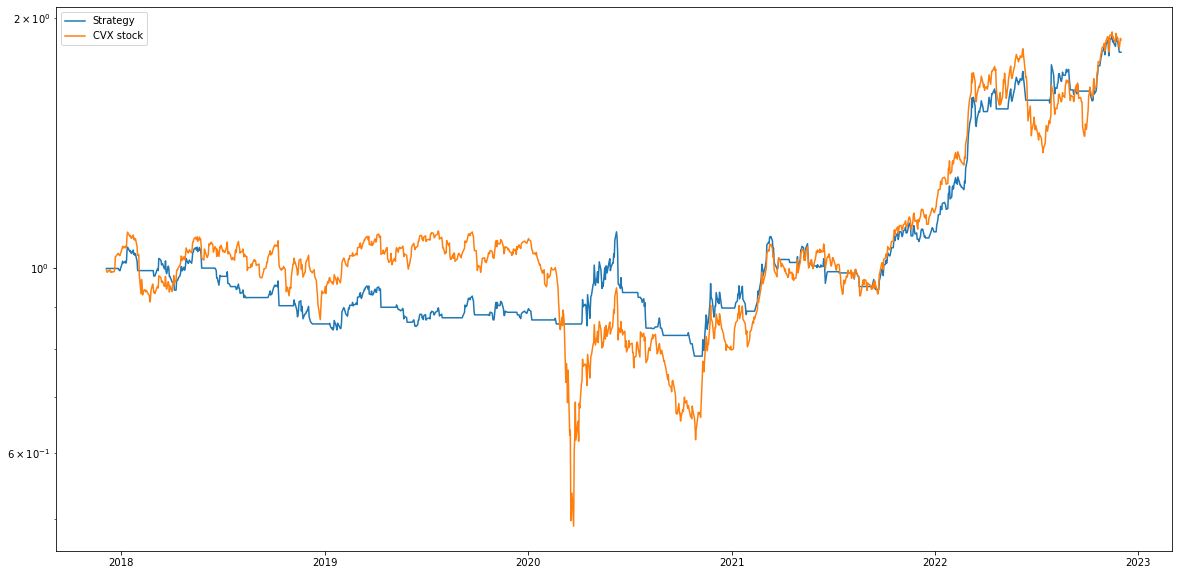

In [117]:
df = pd.DataFrame()
df[stock] = agg[stock].sort_index(ascending=True)
portfolio = [1 if df[stock].rolling(window=15).mean().pct_change()[_] > 0 else 0 for _ in df.index]
df_port = pd.DataFrame(portfolio[:-1], index=df.index[1:], columns=["Allocation"])
stock_returns = returns[stock_return].sort_index(ascending=True)
plt.plot(np.cumprod(1 + np.multiply(df_port["Allocation"], stock_returns)))
plt.plot(np.cumprod(1 + stock_returns))
plt.legend(["Strategy", "CVX stock"])
plt.yscale('log')

In [118]:
sharpe_ratio(np.multiply(df_port["Allocation"], stock_returns))

0.6039631842151449

In [119]:
excess_sharpe_ratio = sharpe_ratio(np.multiply(df_port["Allocation"], stock_returns)) - sharpe_ratio(stock_returns)
excess_sharpe_ratio

0.2239617115176451

In [120]:
drawdown(np.multiply(df_port["Allocation"], stock_returns))*100

-29.082267345156342

In [121]:
drawdown(np.multiply(df_port["Allocation"], stock_returns))/annualized_vol(np.multiply(df_port["Allocation"], stock_returns))

-1.3798637006046892

We have a slightly better sharp ratio and a good drawdown/annualized_volatility.

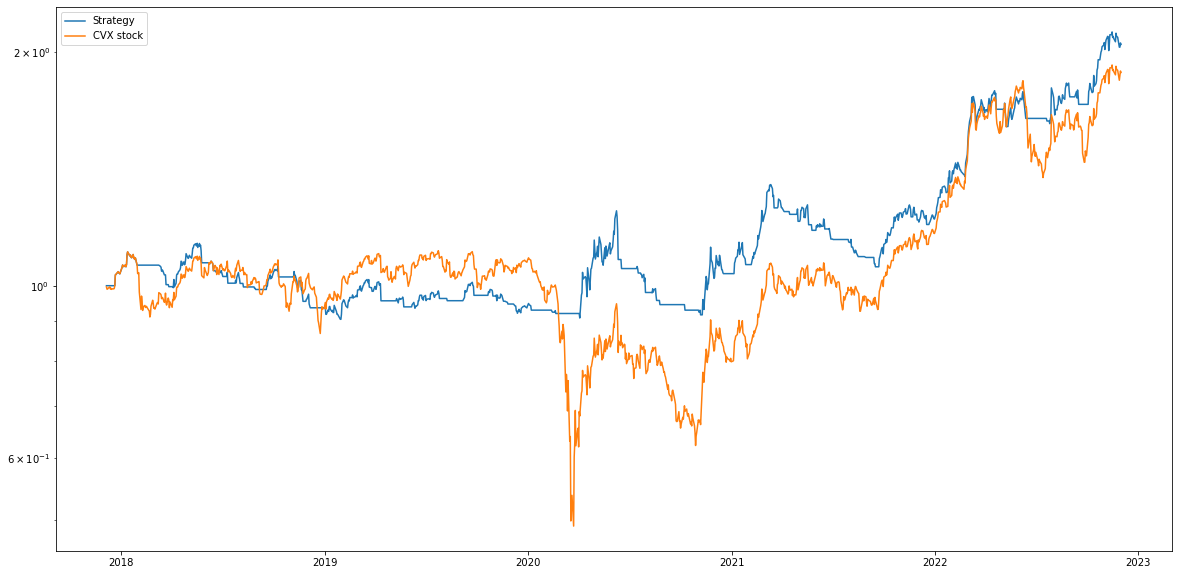

In [142]:
portfolio = [1 if df[stock].ewm(span=20, adjust=False).mean().pct_change()[_] > 0 else 0 for _ in df.index]
df_port = pd.DataFrame(portfolio[:-1], index=df.index[1:], columns=["Allocation"])
stock_returns = returns[stock_return].sort_index(ascending=True)

plt.plot(np.cumprod(1 + np.multiply(df_port["Allocation"], stock_returns)))
plt.plot(np.cumprod(1 + stock_returns))
plt.legend(["Strategy", "CVX stock"])
plt.yscale('log')

In [143]:
sharpe_ratio(np.multiply(df_port["Allocation"], stock_returns))

0.7277668575379999

In [144]:
excess_sharpe_ratio = sharpe_ratio(np.multiply(df_port["Allocation"], stock_returns)) - sharpe_ratio(stock_returns)
excess_sharpe_ratio

0.3477653848405

In [145]:
drawdown(np.multiply(df_port["Allocation"], stock_returns))*100

-26.527157665671087

In [146]:
drawdown(np.multiply(df_port["Allocation"], stock_returns))/annualized_vol(np.multiply(df_port["Allocation"], stock_returns))

-1.2449285272214574

In the case of the CVX stock, we obtain a better sharp ratio using an exponential weighted average.

### Commentary :
Here we opted for a simple trend strategy with long positions (without shorting). Indeed, we opted for a trend following using a moving average or an exponential weighted average. Normally, an EWA is expected to give better results, but as we've seen, it can't be taken a general rule, depending on the trend of the stock's returns.  
In order to do so for a portfolio of stocks, it is recommended that we treat each stock by determining the best metric to use in a trend following strategy (with the best window for a moving average or the best span for exponential weighted average). We can from then either normalize using each stock's weight in the DIJ index or use equal weights in our portfolio.  
A better extension of this strategy is to consider a Long/Short trend following strategy.